In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering, memory_summarizer, event_summarizer, attack_graph_inference, exploitation_manager, firewall_executor, save_iteration, tools_network_gathering, tools_firewall
from state import HoneypotStateReact
import memory
import json
nest_asyncio.apply()
import benchmark as b



def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-3.5-turbo",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [ ]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "save_iteration"]:
    last_message = state.messages[-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools_firewall"
    
    return "save_iteration"


In [11]:
def build_react_graph():
    graph = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    graph.add_node("network_gathering", network_gathering)
    graph.add_node("memory_summarizer", memory_summarizer)
    graph.add_node("event_summarizer", event_summarizer)
    graph.add_node("attack_graph_inference", attack_graph_inference)
    graph.add_node("exploitation_manager", exploitation_manager)
    graph.add_node("firewall_executor", firewall_executor)
    graph.add_node("save_iteration", save_iteration)
    graph.add_node("tools_firewall", tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "memory_summarizer")
    graph.add_edge("memory_summarizer", "event_summarizer")
    graph.add_edge("event_summarizer", "attack_graph_inference")
    graph.add_edge("attack_graph_inference", "exploitation_manager")
    graph.add_edge("exploitation_manager", "firewall_executor")
    graph.add_conditional_edges("firewall_executor", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "save_iteration")
    graph.add_edge("save_iteration", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:49713/devtools/browser/ae688386-5628-42bf-adec-74020beb21dc
INFO:pyppeteer.launcher:terminate chrome process...


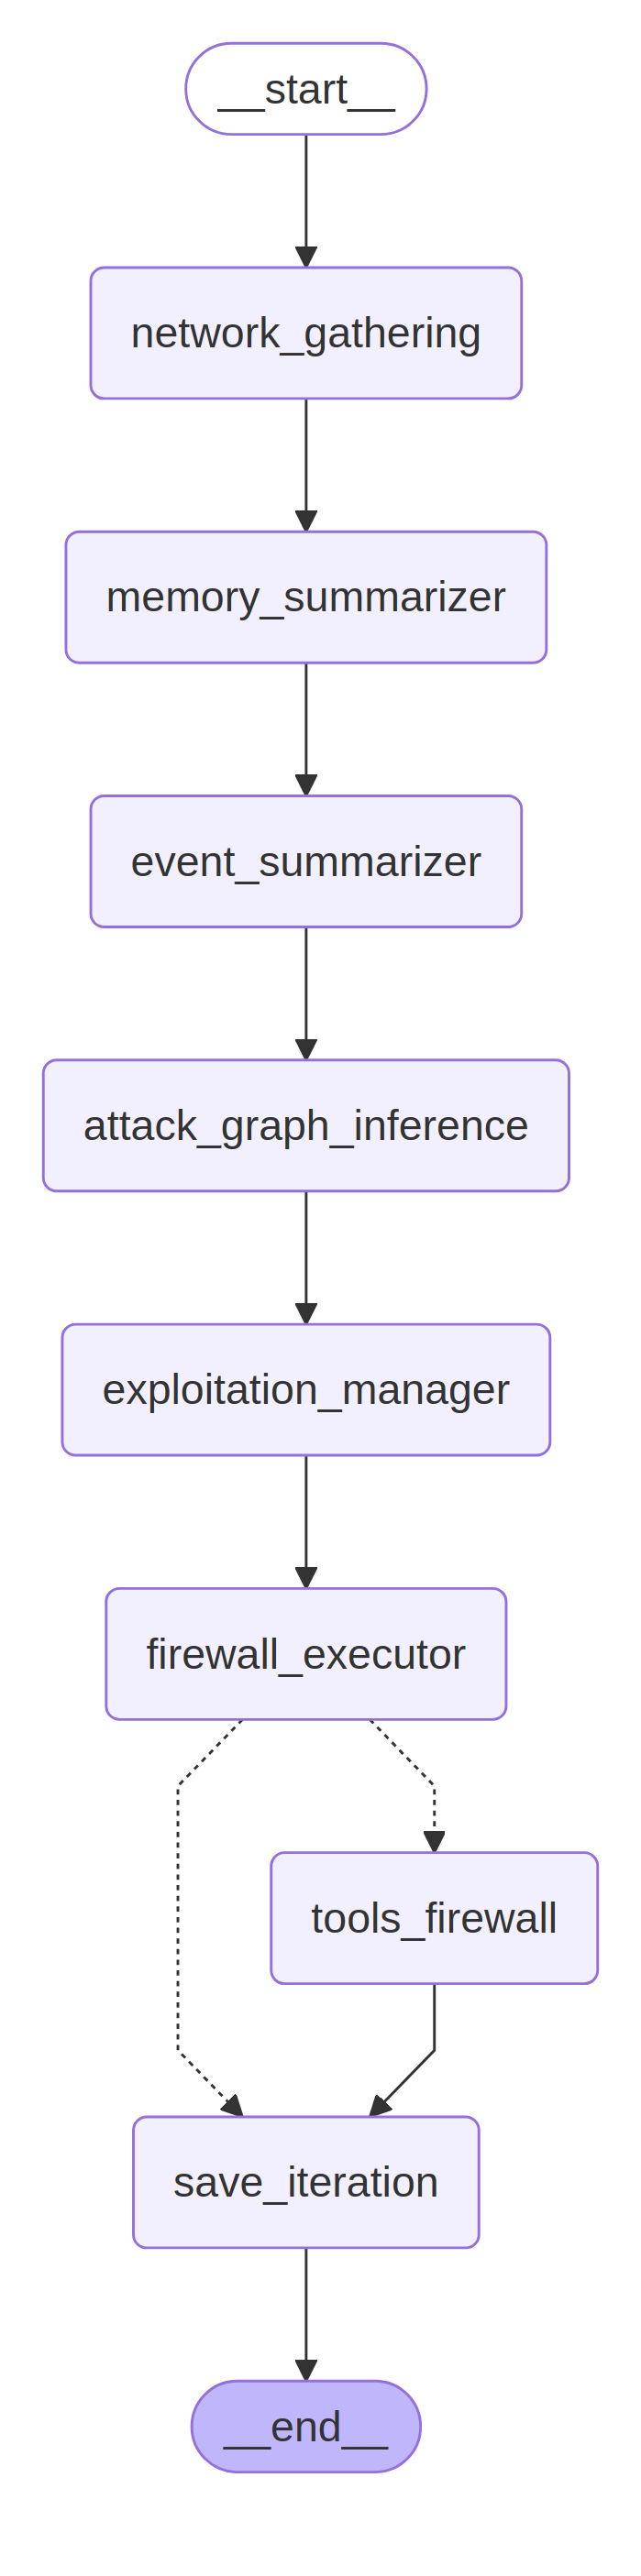

In [12]:
graph = build_react_graph()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()
initial_state = HoneypotStateReact(
    messages="Analyze the honeypot data, infer the attack graph and lead to maximum exploitation"
)
response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory}})

INFO:nodes:Network gathering Node
INFO:nodes:Summarizer Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inference Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Exploitation Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Firewall Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: BLOCK 192.168.100.0/24 -> 172.20.0.2)
INFO:tools:Adding block rule: BLOCK 172.20.0.2 -> 192.168.100.0/24)
INFO:tools:Adding block rule: BLOCK 192.168.100.0/24 -> 172.20.0.3)
INFO:tools:Adding block rule: BLOCK 172.20.0.3 -> 192.168.100.0/24)
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1


In [7]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze the honeypot data, infer the attack graph and lead to maximum exploitation
================================== Ai Message ==================================

Attack Graph:
[]

Honeypots exploitation:
[
  {
    "ip": "172.20.0.7",
    "service": "gitlab-proxy",
    "exploitation_level": 0,
    "status": "unexposed"
  },
  {
    "ip": "172.20.0.6",
    "service": "cve-2021-22205-gitlab-1",
    "exploitation_level": 0,
    "status": "unexposed"
  },
  {
    "ip": "172.20.0.3",
    "service": "s2-057-struts2-1",
    "exploitation_level": 0,
    "status": "unexposed"
  },
  {
    "ip": "172.20.0.2",
    "service": "unauthorized-rce-docker-1",
    "exploitation_level": 0,
    "status": "unexposed"
  }
]

Reasoning: No alerts, scans, or exploits were detected for any honeypot in this epoch. No evidence is present to justify adding any honeypot to the attack graph or increasing exploitation levels. All hon

In [9]:
for i in episodic_memory.get_recent_iterations():
    for k,v in i.value.items():
        if "exposed" in k:
            print(f"Key: {k}\nValue: {v}")

Key: currently_exposed
Value: {'gitlab-proxy': {'service': 'nginx (proxy)', 'exploitation_level': '0%', 'status': 'unexposed'}, 'cve-2021-22205-gitlab-1': {'service': 'gitlab', 'exploitation_level': '0%', 'status': 'unexposed'}, 's2-057-struts2-1': {'service': 'struts2', 'exploitation_level': '0%', 'status': 'unexposed'}, 'unauthorized-rce-docker-1': {'service': 'docker remote API', 'exploitation_level': '0%', 'status': 'unexposed'}}


## Docker + Struts + Gitlab

In [6]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts + Gitlab - MultiAgentArchitecture"
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
async def my_agent_executor(epoch_num: int):
    return await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

In [14]:
for i, ep in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 120)
    print(f"Iteration: {i}")
    for k,v in ep.value.items():
        if "lockdown" in k:
            print(f"Key: {k}\nValue: {v}")
    print("=" * 120)

Iteration: 0
Key: lockdown_status
Value: False
Iteration: 1
Key: lockdown_status
Value: False
Iteration: 2
Key: lockdown_status
Value: False
Iteration: 3
Key: lockdown_status
Value: False
Iteration: 4
Key: lockdown_status
Value: False
Iteration: 5
Key: lockdown_status
Value: False
Iteration: 6
Key: lockdown_status
Value: True
Iteration: 7
Key: lockdown_status
Value: True
Iteration: 8
Key: lockdown_status
Value: True
Iteration: 9
Key: lockdown_status
Value: True
